In [1]:
%run lib.py

# load and preprocess text

In [ ]:
raw = []
with open('data/papers.txt') as f:
    for l in f.readlines():
        j = json.loads(l)
        raw += [j]

In [ ]:
pap = (
    pd.DataFrame(raw)
    .drop('_id', axis=1)
    .rename(columns={'ab':'abstract', 
                     'au': 'authors', 
                     'kw': 'keywords', 
                     'ln': 'link', 
                     'pb': 'publication', 
                    'tl': 'title',
                    'hl': 'highlights',
                    'q': 'query'})
    .loc[:, ['title', 'authors', 'abstract', 'highlights', 'publication', 'keywords', 'query', 'link']]
)
pap.to_csv('papers.csv.zip', index_col=None)

---

In [9]:
pap = pd.read_csv('papers.csv.zip', index_col=0)

In [17]:
print(pap.head(2).T.to_latex(longtable=True))

\begin{longtable}{lll}
\toprule
{} &                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0 &                                                                                                                                                                                                                                                                                                                        

In [213]:

def find_dates(y):
    return list(datefinder.find_dates(y, base_date=datetime(1, 1, 1)))

def filter_dates(y):
    return [x for x in y if x > datetime(1900, 1, 1) and x <= datetime(2019, 12, 1)]


publ = (
    pap['publication'].apply(html.unescape)
    .str.split(';', expand=True)
    .loc[:, [0, 1, 4]]
    .rename(columns={
        0: 'journal',
        1: 'volume',
        4: 'date',
    })
    .loc[lambda x: x['volume'].str.contains(r'vol|online', case=False)]
    .assign(
        date=lambda x: x['date'].combine_first(x['volume'])\
                                .str.replace('Available online ', ''),
        date_parsed=lambda x: x['date']\
                              .apply(find_dates)\
                              .apply(filter_dates),
        volume=lambda x: x['volume'].str.replace(r'Available online .*', '')
    )
    .loc[lambda x: x['date_parsed'].apply(len) == 1]
    .assign(date_parsed=lambda x: x['date_parsed'].apply(lambda y: y[0]))
)

In [214]:
pap_publ = pd.concat((pap, publ), axis=1)

In [217]:
pap_publ = pap_publ.set_index('Unnamed: 0')

In [219]:
pap_publ.head()

,title,authors,abstract,highlights,publication,keywords,query,link,journal,volume,date,date_parsed
Unnamed: 0,,,,,,,,,,,,
0,"To cluster, or not to cluster: An analysis of clusterability methods",Author links open overlay panel; Andreas; Adolfsson; a; Margareta; Ackerman; 1; a; Naomi C.; Brownstein; 1; b,"Abstract Clustering is an essential data mining tool that aims to discover inherent cluster structure in data. For most applications, applying clustering is only appropriate when cluster structure is present. As such, the study of clusterability, which evaluates whether data possesses such structure, is an integral part of cluster analysis. However, methods for evaluating clusterability vary radically, making it challenging to select a suitable measure. In this paper, we perform an extensive comparison of measures of clusterability and provide guidelines that clustering users can reference to select suitable measures for their applications.",Highlights • The paper surveys and compares clusterability tests. • New clusterability tests are proposed. • Type I error and power of clusterability methods are reported for simulated data. • Clusterablity tests are applied to well-known non-simulated data. • Provide guidelines to help users to select among clusterability tests.,"Pattern Recognition; Volume 88; , ; ; April 2019; ; , Pages 13-26",Clusterability; Cluster structure; Cluster tendency; Dimension reduction; Multimodality tests,clustering,/science/article/pii/S0031320318303777,Pattern Recognition,Volume 88,April 2019,2019-04-01
1,Group actions on cluster algebras and cluster categories,Author links open overlay panel; Charles; Paquette; a; Ralf; Schiffler; b,"Abstract We introduce admissible group actions on cluster algebras, cluster categories and quivers with potential and study the resulting orbit spaces. The orbit space of the cluster algebra has the structure of a generalized cluster algebra. This generalized cluster structure is different from those introduced by Chekhov–Shapiro and Lam–Pylyavskyy. For group actions on cluster algebras from surfaces, we describe the generalized cluster structure of the orbit space in terms of a triangulated orbifold. In this case, we give a complete list of exchange polynomials, and we classify the algebras of rank 1 and 2. We also show that every admissible group action on a cluster category induces a precovering from the cluster category to the cluster category of orbits. Moreover this precovering is dense if the categories are of finite type.",NaN,"Advances in Mathematics; Volume 345; , ; ; 17 March 2019; ; , Pages 161-221",Cluster algebra; Generalized cluster algebra; Orbifold; Cluster category; Group action,clustering,/science/article/pii/S0001870819300349,Advances in Mathematics,Volume 345,17 March 2019,2019-03-17
2,Clustering ensemble based on sample's stability,Author links open overlay panel; Feijiang; Li; a; Yuhua; Qian; a; b; Jieting; Wang; a; Chuangyin; Dang; c; Liping; Jing; d,"Abstract The objective of clustering ensemble is to find the underlying structure of data based on a set of clustering results. It has been observed that the samples can change between clusters in different clustering results. This change shows that samples may have different contributions to the detection of the underlying structure. However, the existing clustering ensemble methods treat all sample equally. To tackle this deficiency, we introduce the stability of a sample to quantify its contribution and present a methodology to determine this stability. We propose two formulas accord with this methodology to calculate sample's stability. Then, we develop a clustering ensemble algorithm based on the sample's stability. With either formula, this algorithm divides a data set into two classes: cluster core and cluster halo. With the core and halo, the proposed algorithm then discovers a clear structure using the samples in the cluster core and assigns samples in the cluster halo to the clear structure gr

In [225]:
pap_publ.to_csv('papers_parsed.csv')

In [7]:
pap_publ.columns

Index(['title', 'authors', 'abstract', 'highlights', 'publication', 'keywords',
       'query', 'link', 'journal', 'volume', 'date', 'date_parsed'],
      dtype='object')

In [25]:
meta = dict([
    ('title', 'Заголовок статьи'),
    ('authors', 'Список авторов'),
    ('abstract', 'Аннотация'),
    ('highlights', 'Основные моменты'),
    ('publication', 'Информация об издании (журнал, том, страницы и т.п)'),
    ('keywords', 'Список ключевых слов'),
    ('query', 'Запрос, с помощью которого была получена статья'), 
    ('link', 'Ссылка на статью на сайте издателя'),
    ('journal', 'Название журнала, извлеченное из поля publication'), 
    ('volume', 'Номер тома, извлеченный из поля publication'), 
    ('date', 'Дата публикации, извлеченная из поля publication'), 
    ('date_parsed', 'Дата в формате YYYY-MM-DD, выделенная из поля date')
])

with open('papers_parsed.csv.md', 'w') as f:
    f.write(pd.Series(meta).to_string())

---

In [4]:
pap_publ = pd.read_csv('papers_parsed.csv', index_col=0)

In [5]:
pap_publ.shape

(68933, 12)

## Filter by journal

In [26]:
pap_publ['query'].value_counts()

neural networks                5467
clustering                     5407
software                       5219
machine learning               5033
algorithm                      4882
bayesian                       4841
classification                 4752
natural language processing    4642
regression                     4563
pattern recognition            4385
support vector                 4371
probabilistic                  4228
information retrieval          3878
search%20engine                3522
artificial intelligence        3116
computing                      586 
deep learning                  41  
Name: query, dtype: int64

In [28]:
journal_counts = pap_publ['journal'].str.lower().value_counts()

journals_g15 = journal_counts.index[journal_counts > 15].values
relevant_journals = pd.read_excel('journals_m.xlsx', 1)['journal'].values

In [29]:
pap_publ_relevant = pap_publ[
    pap_publ['journal'].str.lower().isin(relevant_journals) &
    pap_publ['journal'].str.lower().isin(journals_g15)
]

In [30]:
pap_publ_relevant.shape

(26823, 12)

In [31]:
pap_publ_relevant['journal'].value_counts()

Neurocomputing                                              3187
Expert Systems with Applications                            2033
Procedia Computer Science                                   1933
Pattern Recognition                                         1360
Applied Soft Computing                                      1236
Information Sciences                                        1211
Pattern Recognition Letters                                 1001
Knowledge-Based Systems                                     820 
Journal of Systems and Software                             760 
IFAC Proceedings Volumes                                    743 
Information and Software Technology                         688 
Neural Networks                                             661 
Computational Statistics & Data Analysis                    628 
Information Processing & Management                         549 
Engineering Applications of Artificial Intelligence         500 
NeuroImage               

In [32]:
pap_publ = pap_publ_relevant

In [103]:
pap_publ.to_csv('papers_parsed_relevant.csv')

---

In [33]:
pap_publ = pd.read_csv('papers_parsed_relevant.csv', index_col=0, parse_dates=True)\
    .assign(date_parsed=lambda x: x['date_parsed'].apply(pd.to_datetime))

In [37]:
pap_publ.shape

(26823, 12)

In [40]:
pap_publ.date_parsed.min(), pap_publ.date_parsed.max()

(Timestamp('1971-01-01 00:00:00'), Timestamp('2019-12-01 00:00:00'))

In [167]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('ggplot')

plt.rcParams['figure.figsize']

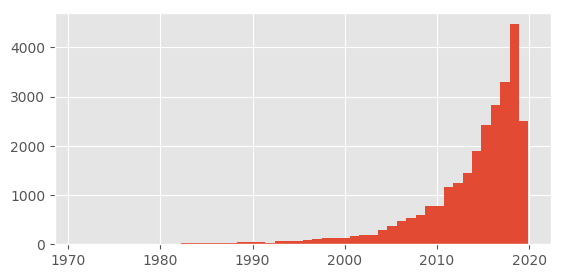

In [170]:
plt.figure(figsize=(6.4, 3))
ax = pap_publ.date_parsed.hist(bins=2019-1971)
plt.savefig('images/papers_date_hist.eps', bbox_inches='tight')

In [143]:
print(pap_publ.groupby('journal')\
.agg({'date_parsed': ['min', 'max'], 'title': 'count', 'volume': lambda x: x.nunique()})\
.sort_values(('title', 'count'), ascending=False)\
.assign(
    period=lambda x: (x[('date_parsed', 'min')].dt.year.astype(str) + '-' + x[('date_parsed', 'max')].dt.year.astype(str))
)\
.drop(['date_parsed'], axis=1)\
# .head(15)\
.to_latex())

\begin{tabular}{lrrl}
\toprule
{} & title &   volume &     period \\
{} & count & \multicolumn{2}{l}{<lambda>} \\
journal                                                  &       &          &            \\
\midrule
Neurocomputing                                           &  3187 &  334 &  1992-2019 \\
Expert Systems with Applications                         &  2033 &  243 &  1998-2019 \\
Procedia Computer Science                                &  1933 &  139 &  2010-2019 \\
Pattern Recognition                                      &  1360 &  301 &  1973-2019 \\
Applied Soft Computing                                   &  1236 &  117 &  2003-2019 \\
Information Sciences                                     &  1211 &  350 &  1998-2019 \\
Pattern Recognition Letters                              &  1001 &  292 &  1982-2019 \\
Knowledge-Based Systems                                  &  820 &  210 &  1988-2019 \\
Journal of Systems and Software                          &  760 &  202 &  1998-201

In [35]:
print(pap_publ['journal'].value_counts().head(15).to_latex())

\begin{tabular}{lr}
\toprule
{} &  journal \\
\midrule
Neurocomputing                                      &  3187 \\
Expert Systems with Applications                    &  2033 \\
Procedia Computer Science                           &  1933 \\
Pattern Recognition                                 &  1360 \\
Applied Soft Computing                              &  1236 \\
Information Sciences                                &  1211 \\
Pattern Recognition Letters                         &  1001 \\
Knowledge-Based Systems                             &  820 \\
Journal of Systems and Software                     &  760 \\
IFAC Proceedings Volumes                            &  743 \\
Information and Software Technology                 &  688 \\
Neural Networks                                     &  661 \\
Computational Statistics \& Data Analysis            &  628 \\
Information Processing \& Management                 &  549 \\
Engineering Applications of Artificial Intelligence &  500 \\
\botto

In [36]:
pap_publ['journal'].nunique()

80

## EDA

In [46]:
journals = pap_publ['journal'].str.lower().value_counts()


In [47]:
journals.quantile(0.99)

376.64000000000306

In [48]:
(journals > 100).sum()

134

In [49]:
journals[journals > 100]

neurocomputing                                                           3187
expert systems with applications                                         2033
procedia computer science                                                1933
pattern recognition                                                      1360
applied soft computing                                                   1236
information sciences                                                     1211
pattern recognition letters                                              1001
knowledge-based systems                                                  820 
journal of systems and software                                          760 
ifac proceedings volumes                                                 743 
information and software technology                                      688 
neural networks                                                          661 
computational statistics & data analysis                        

In [50]:
(journals < 15).sum()

1648

In [11]:
journals.to_frame().reset_index().sort_values('index')\
    .rename(columns={'index': 'journal',
                     'journal': 'count'})\
    .to_excel('journals.xlsx', index=False)

In [231]:
pap_publ['date_parsed'].min(), pap_publ['date_parsed'].max()

(Timestamp('1971-01-01 00:00:00'), Timestamp('2019-12-01 00:00:00'))

In [233]:
pap_publ.loc[lambda x: x['date_parsed'] > datetime.now(), ].drop(['highlights', 'abstract'], axis=1)

,title,authors,publication,keywords,query,link,journal,volume,date,date_parsed
Unnamed: 0,,,,,,,,,,
4,An improved algorithm for partial clustering,Author links open overlay panel; G.; Melendez-Melendez; D.; Cruz-Paz; J.A.; Carrasco-Ochoa; José Fco.; Martínez-Trinidad,"Expert Systems with Applications; Volume 121; , ; ; 1 May 2019; ; , Pages 282-291",Clustering; Estimation of the number of clusters; Outlier detection,clustering,/science/article/pii/S0957417418307966,Expert Systems with Applications,Volume 121,1 May 2019,2019-05-01
9,Estimating the number of clusters in a dataset via consensus clustering,Author links open overlay panel; Ramazan; Ünlü; a; Petros; Xanthopoulos; b,"Expert Systems with Applications; Volume 125; , ; ; 1 July 2019; ; , Pages 33-39",Weighted consensus clustering; Validity indices; Number of clusters,clustering,/science/article/pii/S0957417419300892,Expert Systems with Applications,Volume 125,1 July 2019,2019-07-01
24,Geometric clustering in normed planes,Author links open overlay panel; Pedro; Martín; a; 1; Diego; Yáñez; b,"Computational Geometry; Volume 78; , ; ; June 2019; ; , Pages 50-60",Geometric clustering; Normed plane,clustering,/science/article/pii/S0925772118301925,Computational Geometry,Volume 78,June 2019,2019-06-01
35,Unsupervised fuzzy model-based Gaussian clustering,Author links open overlay panel; Miin-Shen; Yang; a; Shou-Jen; Chang-Chien; a; Yessica; Nataliani; a; b,"Information Sciences; Volume 481; , ; ; May 2019; ; , Pages 1-23",Clustering; Model-based clustering; Gaussian mixtures; Fuzzy sets; Fuzzy clustering; Fuzzy model-based clustering; Unsupervised learning schema,clustering,/science/article/pii/S0020025518310089,Information Sciences,Volume 481,May 2019,2019-05-01
128,Approximate spectral clustering with eigenvector selection and self-tuned k,Author links open overlay panel; Mashaan; Alshammari; Masahiro; Takatsuka,"Pattern Recognition Letters; Volume 122; , ; ; 1 May 2019; ; , Pages 31-37",MSC; 41A05; 41A10; 65D05; 65D17,clustering,/science/article/pii/S0167865519300315,Pattern Recognition Letters,Volume 122,1 May 2019,2019-05-01
134,Application of reinforcement learning in UAV cluster task scheduling,Author links open overlay panel; Jun; Yang; a; Xinghui; You; a; Gaoxiang; Wu; a; Mohammad Mehedi; Hassan; b; Ahmad; Almogren; b; Joze; Guna; c,"Future Generation Computer Systems; Volume 95; , ; ; June 2019; ; , Pages 140-148",Reinforcement learning; UAV cluster; Task scheduling,clustering,/science/article/pii/S0167739X18325299,Future Generation Computer Systems,Volume 95,June 2019,2019-06-01
140,Good (K-means) clusterings are unique (up to small perturbations),Author links open overlay panel; Marina; Meilă,"Journal of Multivariate Analysis; Volume 173; , ; ; September 2019; ; , Pages 1-17",AMS subject classificaition; primary; 62H30; secondary; 91C20; 15A18; 15B57,clustering,/science/article/pii/S0047259X18300964,Journal of Multivariate Analysis,Volume 173,September 2019,2019-09-01
155,Clustering of multi-view relational data based on particle swarm optimization,Author links open overlay panel; Renê Pereira; de Gusmão; a; b; Francisco de A.T.; de Carvalho; a,"Expert Systems with Applications; Volume 123; , ; ; 1 June 2019; ; , Pages 34-53",PSO; Cluster analysis; Multi-view clustering; Relational data,clustering,/science/article/pii/S0957417418308248,Expert Systems with Applications,Volume 123,1 June 2019,2019-06-01
157,Deep metric learning via subtype fuzzy clustering,Author links open overlay panel; Chuan-Xian; Ren; a; Ju-Zheng; Li; a; Pengfei; Ge; a; Xiao-Lin; Xu; b,"Pattern Recognition; Volume 90; , ; ; June 2019; ; , Pages 210-219",Metric learning; Deep networks; Triplet loss; Fuzzy clustering; Online sampling,clustering,/science/article/pii/S0031320319300548,Pattern Recognition,Volume 90,June 2019,2019-06-01


In [234]:
pap_publ.loc[lambda x: x['date_parsed'] == datetime(2019, 12,1), ].drop(['highlights', 'abstract'], axis=1)

,title,authors,publication,keywords,query,link,journal,volume,date,date_parsed
Unnamed: 0,,,,,,,,,,
231,Prevalence of Symptoms and Symptom Clusters of Patients on Dialysis in Uruguay,"Author links open overlay panel; Ana Inés; Galain; LicPsyc; 1; Juan José; Dapueto; MD, PhD; 1; Ramón; Alvarez; MSc; 2; Liliana; Gadola; MD; 3","Value in Health Regional Issues; Volume 20; , ; ; December 2019; ; , Pages 28-35",dialysis; hierarchical cluster analysis; symptom clusters; Uruguay,clustering,/science/article/pii/S2212109918303558,Value in Health Regional Issues,Volume 20,December 2019,2019-12-01
8056,Short-long term anomaly detection in wireless sensor networks based on machine learning and multi-parameterized edit distance,Author links open overlay panel; Francesco; Cauteruccio; a; Giancarlo; Fortino; a; b; Antonio; Guerrieri; b; Antonio; Liotta; c; Decebal Constantin; Mocanu; d; Cristian; Perra; e; Giorgio; Terracina; a; Maria; Torres Vega; f,"Information Fusion; Volume 52; , ; ; December 2019; ; , Pages 13-30",Intelligent sensing; Sensor fusion; Anomaly detection; Cloud-assisted sensing; Internet of Things,machine learning,/science/article/pii/S1566253518304305,Information Fusion,Volume 52,December 2019,2019-12-01
12201,Multi-channel fusion convolutional neural network to classify syntactic anomaly from language-related ERP components,Author links open overlay panel; Aisha; Khan; a; Jee Eun; Sung; b; Je-Won; Kang; a,"Information Fusion; Volume 52; , ; ; December 2019; ; , Pages 53-61",Event-related potential signals; Convolutional neural network; Sentence classification; Neurological signal processing; Linguistic feature fusion,neural networks,/science/article/pii/S1566253518302240,Information Fusion,Volume 52,December 2019,2019-12-01
38283,Knowledge fusion patterns: A survey,Author links open overlay panel; Alexander; Smirnov; Tatiana; Levashova,"Information Fusion; Volume 52; , ; ; December 2019; ; , Pages 31-40",Knowledge fusion; Knowledge fusion patterns,pattern recognition,/science/article/pii/S1566253518304391,Information Fusion,Volume 52,December 2019,2019-12-01
55683,Normative data from linear and nonlinear quantile regression in CANTAB: Cognition in mid-to-late life in an epidemiological sample,Author links open overlay panel; Rosemary A.; Abbott; a; Caroline; Skirrow; a; Martha; Jokisch; b; Maarten; Timmers; c; d; Johannes; Streffer; c; d; 1; Luc; van Nueten; c; Michael; Krams; e; Angela; Winkler; b; Noreen; Pundt; f; Pradeep J.; Nathan; a; 2; Philippa; Rock; a; Francesca K.; Cormack; a; Christian; Weimar; b,"Alzheimer&#x27;s &amp; Dementia: Diagnosis, Assessment &amp; Disease Monitoring; Volume 11; , ; ; December 2019; ; , Pages 36-44; open access",Normative data; Episodic memory; Cognition; Aging; Dementia; Mild cognitive impairment,regression,/science/article/pii/S2352872918300757,"Alzheimer's & Dementia: Diagnosis, Assessment & Disease Monitoring",Volume 11,December 2019,2019-12-01
